# Imports and definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from numpy.random import random, poisson, choice
sys.path.append("C:/Users/jakob/Documents/MLandData/OtherFiles")
import Alexandria as lib
from importnb import Notebook
with Notebook(): 
    from inferrence import infer



alpha = 0.9
beta = 0.2
gamma = 0.1
lambdas = np.array([1,5])

n = 10
T = 100

# Define the forward simulation

In [2]:
def simulate(n,T,C0 = 2, alpha = alpha, beta = beta, gamma = gamma, lambdas = lambdas):
    # Initialize the data arrays
    C = np.empty(T,dtype = int)
    z = np.empty((T,n),dtype = int)
    x = np.empty((T,n))

    # Define the probability for getting z = 1 given a C
    PZ1 = [1 - alpha, alpha, 0.5]

    # Define the Gamma matrix 
    Gamma = np.array([[1-gamma,0,gamma],[0,1-gamma,gamma],[beta/2,beta/2,1-beta]])

    # Loop over T iterations
    for t in range(T):
        # Find the C depending on the Gamma-matrix and the former C
        C[t] = choice([0,1,2], p = Gamma[C[t-1]]) if t > 0 else C0

        # With a probability depending on alpha and C, choose the Z's
        z[t] = random(n) <= PZ1[C[t]]

        # Draw the x's from a poisson depending on their z's and lambdas
        x[t] = poisson(lambdas[z[t]])

    return (C,z,x)


# Learning of parameters

In [104]:
clamp = lambda x, a, b: max(min(b,x),a)

def calc_parameters(X,z,C):
    
    lambda0 = np.mean(X[z == 0])
    lambda1 = np.mean(X[z == 1])
    lambdas = np.array([lambda0,lambda1])

    zc0 = z[C == 0]
    zc1 = z[C == 1]

    alphas = []
    if len(zc0.flatten()-1) > 0:
        alpha0 = 1-np.sum(zc0 == 1)/len(zc0.flatten()-1)
        alphas.append(alpha0)
    if len(zc1.flatten()-1) > 0:
        alpha1 = np.sum(zc1 == 1)/len(zc1.flatten()-1)
        alphas.append(alpha1)


    alpha_guess = clamp(np.mean(alphas),0.5,1)


    C00 = sum((C == 0)[1:] * (C == 0)[:-1])
    C10 = sum((C == 1)[1:] * (C == 0)[:-1])
    C20 = sum((C == 2)[1:] * (C == 0)[:-1])

    C01 = sum((C == 0)[1:] * (C == 1)[:-1])
    C11 = sum((C == 1)[1:] * (C == 1)[:-1])
    C21 = sum((C == 2)[1:] * (C == 1)[:-1])

    C02 = sum((C == 0)[1:] * (C == 2)[:-1])
    C12 = sum((C == 1)[1:] * (C == 2)[:-1])
    C22 = sum((C == 2)[1:] * (C == 2)[:-1])

    C0 = C00 + C10 + C20
    C1 = C01 + C11 + C21 
    C2 = C02 + C12 + C22

    gammas = []


    if C0 != 0:
        gamma2 = 1-C00/C0
        gammas.append(gamma2)
        gamma0 = C02/C0
        gammas.append(gamma0)
    if C1 != 0:
        gamma3 = 1-C11/C1
        gammas.append(gamma3)
        gamma1 = C12/C1
        gammas.append(gamma1)


    gamma_guess = clamp(np.mean(gammas),0,1)
    
    betas = []
    if C2 > 0:
        b0 = 2*C20/C2
        betas.append(b0)
     
        b1 = 2*C21/C2
        betas.append(b1)

        b2 = 1 - C22/C2
        betas.append(b2)

    beta_guess = clamp(np.mean(betas),0,1)

    return (alpha_guess, beta_guess, gamma_guess, lambdas)




alpha = 0.9
beta = 0.5
gamma = 0.1
lambdas = np.array([1,5]).astype(float)

n, T = 10, 1000
C, z, X = simulate(n, T, 2, alpha, beta, gamma, lambdas)

alpha_guess, beta_guess, gamma_guess, lambda_guess = calc_parameters(X,z,C)


print(f"Alpha: {alpha:.3}", f"Alpha guess: {alpha_guess:.3}" )

print(f"Beta: {beta:.3}",f"Beta guess: {beta_guess:.3}")


print(f"Gamma: {gamma:.3}",f"Gamma guess: {gamma_guess:.3}")

print(f"Lambdas: ({lambdas[0]:.3},{lambdas[1]:.3})",f"Lambda guess': ({lambda_guess[0]:.3},{lambda_guess[1]:.3})")



Alpha: 0.9 Alpha guess: 0.903
Beta: 0.5 Beta guess: 0.453
Gamma: 0.1 Gamma guess: 0.111
Lambdas: (1.0,5.0) Lambda guess': (0.994,4.99)


In [99]:
alpha = 0.9
beta = 0.5
gamma = 0.1
lambdas = np.array([1,5]).astype(float)


iterations = 10

n, T = 10, 100*10

Cs, zs, Xs = np.empty((iterations,T)), np.empty((iterations,T,n)), np.empty((iterations,T,n))

for i in range(iterations):
    Cs[i], zs[i], Xs[i] = simulate(n, T, 2, alpha, beta, gamma, lambdas)

N = 7

qual = np.empty((N, iterations,5))
print("Done simulating")
for _nnn in range(N):
    break
    nnn = (_nnn*10 + 1) * 10
    for i in range(iterations):
        alpha_guess, beta_guess, gamma_guess, lambda_guess = calc_parameters(Xs[i,:nnn],zs[i,:nnn],Cs[i,:nnn])

        diffs = np.abs([alpha-alpha_guess, beta-beta_guess, gamma-gamma_guess, lambdas[0]-lambda_guess[0], lambdas[1]-lambda_guess[1]])

        qual[_nnn, i] = np.array(diffs)




Done simulating


# Hard EM 

In [70]:
def hard_EM(X,C,N = 1000):
    alpha = random()/2.01+0.5001
    beta = random()/100+0.001
    gamma = random()/100 + 0.001
    lambdas = np.array([1, 2])

    parameters = np.array([alpha, beta, gamma, lambdas])

    Cs = np.random.randint(0,3,X.shape[0])
    zs = np.random.randint(0,2,X.shape)
    C_last = np.random.randint(0,3,X.shape[0])

    for it in range(N):
        Cs, zs = infer(X, alpha, beta, gamma, lambdas)

        parameters = calc_parameters(X, zs, Cs)

        # parameters = (parameters + _parameters)/2
        alpha, beta, gamma, lambdas = parameters

        
        # jit = 500
        # alpha += (random()-0.5)/jit
        # beta += (random()-0.5)/jit
        # gamma += (random()-0.5)/jit
        # lambdas += np.array([(random()-0.5)/jit,(random()-0.5)/jit])
        

        print(parameters)

        change = np.sum(C_last != Cs)
        print(f"Iteration {it}: Changed {change} Cs")

        print(f"Quality: {np.mean(Cs == C)}")

        if change == 0:
            break
        C_last = Cs.copy()
    
    parameters = {'alpha':alpha,'beta':beta,'gamma':gamma,'lambdas':lambdas}
    return (Cs, zs, parameters)


alpha = 0.9
beta = 0.5
gamma = 0.1
lambdas = np.array([1,5])

true_parameters = {'alpha':alpha,'beta':beta,'gamma':gamma,'lambdas':lambdas}
n, T = 10, int(1e4)
C, z, X = simulate(n,T,2,alpha,beta,gamma,lambdas)

Cs, zs, parameters = hard_EM(X,C)

print("Found:",parameters)
print("True: ",true_parameters)
print(np.mean(C==Cs)*100,"% Correct")


C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


(0.7775465118716443, 0.07794815626140926, 0.2478391313397835, array([0.51603514, 4.56390117]))
Iteration 0: Changed 6674 Cs
Quality: 0.4876
(0.8005475191579603, 0.322972830108891, 0.17096021208704654, array([0.52004986, 4.60045911]))
Iteration 1: Changed 4001 Cs
Quality: 0.778
(0.7733163982003228, 0.6082397003745319, 0.10561653475757098, array([0.5201676 , 4.60058435]))
Iteration 2: Changed 1818 Cs
Quality: 0.8672
(0.7410124943829006, 0.8666666666666667, 0.04054655120469667, array([0.5201676 , 4.60058435]))
Iteration 3: Changed 1331 Cs
Quality: 0.8202
(0.7355201144528568, 0.3333333333333333, 0.03350269102705228, array([0.52004986, 4.60045911]))
Iteration 4: Changed 184 Cs
Quality: 0.8152
(0.734712365419321, 0.8418079096045198, 0.036834310777037416, array([0.52004986, 4.60045911]))
Iteration 5: Changed 196 Cs
Quality: 0.8171
(0.7343251763942003, 0.3333333333333333, 0.03239462677741456, array([0.52004986, 4.60045911]))
Iteration 6: Changed 181 Cs
Quality: 0.8142
(0.7340120418337597, 0.82

KeyboardInterrupt: 

In [7]:
n, T = 50, 1000



for i in range(10):
    k = (i+1)/10

    alpha = 0.1
    beta = k
    gamma = 0.1
    lambdas = np.array([1,5])
    C, z, X = simulate(n, T, 2, alpha, beta, gamma, lambdas)

    C_pred = infer(X, i/10, beta, gamma, lambdas)[0]

    print(i/10,np.mean(C_pred == C))


0.0 0.875
0.1 0.995
0.2 0.983
0.3 0.922
0.4 0.802
0.5 0.403
0.6 0.0
0.7 0.0
0.8 0.0
0.9 0.0


In [36]:
X.mean()

3.00636

# Plottings

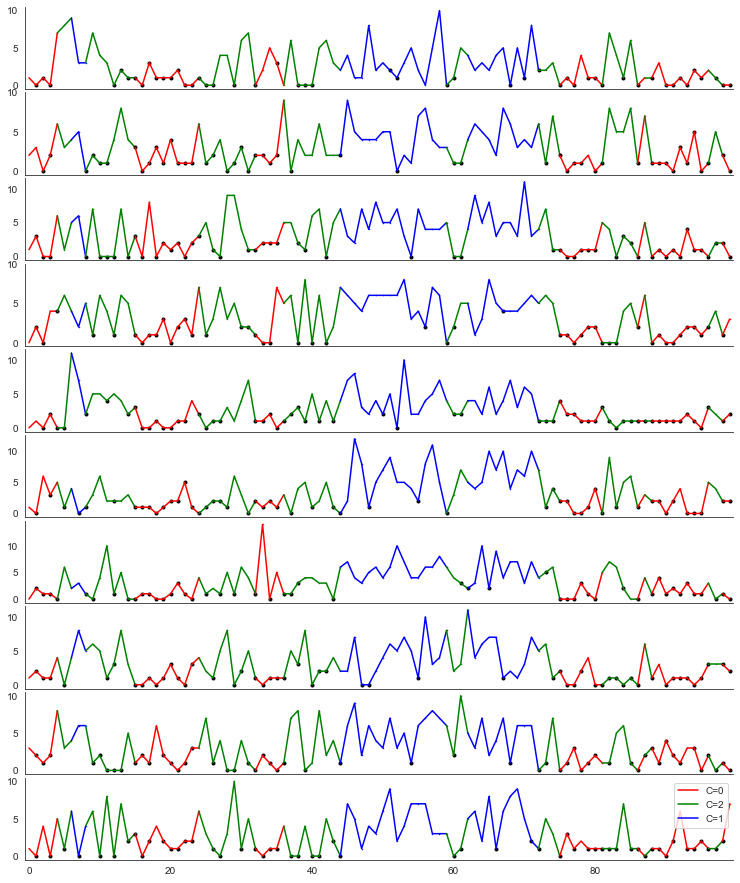

In [82]:
sns.set_style("white")

n, T = 10, 100

C, z, x = simulate(n,T,0)

def plot(x,z,C):
    fig, axs = plt.subplots(n,1,figsize = (10,12),sharex=True)

    x_split = [x[C == i] for i in range(3)]
    x_axis_split = [np.array([xx for xx in range(len(C))])[C == i] for i in range(3)]

    for nn in range(n):

        # axs[nn].plot(x[:,nn],alpha = 0.5)
        # axs[nn].plot(x[:,nn],'.',color= "black")
        cc = C[0]
        lt = 0
        made = np.zeros(3).astype(bool)
        for t in range(1,T):
            axs[nn].plot([t],x[t,nn],'.',color=['red','blue','green'][cc], markersize = 1)
            if cc != C[t]:
                if not made[cc]:
                    made[cc] = True
                    axs[nn].plot([i for i in range(lt,t+1)], x[lt:t+1,nn],color =['red','blue','green'][cc], label = f"C={cc}")

                else:
                    axs[nn].plot([i for i in range(lt,t+1)], x[lt:t+1,nn],color =['red','blue','green'][cc] )
                cc = C[t]
                lt = t
            axs[nn].plot([t],x[t,nn],'.',color='black', alpha = [1,0][z[t,nn]])
            
        axs[nn].plot([i for i in range(lt,t+1)], x[lt:t+1,nn],color =['red','blue','green'][cc] )

        axs[nn].set_xlim(0-0.5,T-0.5)
        axs[nn].set_yticks([0,5,10])

    sns.despine()
    plt.legend()
    plt.tight_layout(pad = -0.3)
    plt.show()


plot(x,z,C)

In [8]:

alpha = 0.9
beta = 0.5
gamma = 0.1
lambdas = np.array([1,5])

true_parameters = {'alpha':alpha,'beta':beta,'gamma':gamma,'lambdas':lambdas}
n, T = 50, 2000
C, z, x = simulate(n,T,2,alpha,beta,gamma,lambdas)

C_pred, z, parameters = hard_EM(x,C)




C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


Iteration 0: Changed 1327 Cs
Quality: 0.8335
Iteration 1: Changed 279 Cs
Quality: 0.973
Iteration 2: Changed 24 Cs
Quality: 0.983
Iteration 3: Changed 1 Cs
Quality: 0.9835
Iteration 4: Changed 1 Cs
Quality: 0.984
Iteration 5: Changed 0 Cs
Quality: 0.984


No handles with labels found to put in legend.


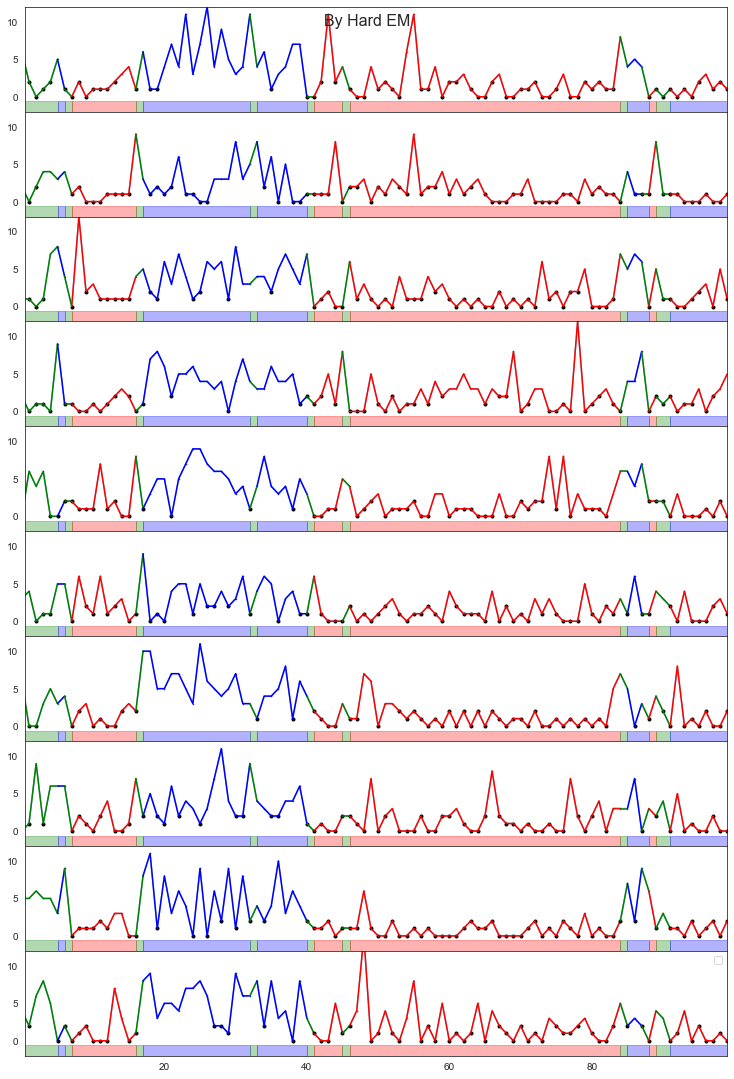

In [11]:
# T = 100
# n = 10
# C, z, X = simulate(n,2*2*50000,2)

# clf = LogisticRegression().fit(X,C)

# C, z, x = simulate(n,T,2)

# C_pred = clf.predict(x)

n = 10
T = 100

fig, axs = plt.subplots(n,1,figsize = (10,15),sharex=True)

x_split = [x[C == i] for i in range(3)]
x_axis_split = [np.array([xx for xx in range(len(C))])[C == i] for i in range(3)]

p = 0.1

for nn in range(n):
    axs[nn].plot(x[:,nn],alpha = 0.5)
    cc = C[0]
    cc_pred = C_pred[0]
    lt = 0
    lt_pred = 0

    made = np.ones(3)

    for t in range(1,T):
        axs[nn].plot([t],x[t,nn],'.',color=['red','blue','green'][cc], markersize = 1)
        if cc != C[t]:
            xxx = [i for i in range(lt,t+1)]

            if not made[cc]:
                made[cc] = True
                axs[nn].plot(xxx, x[lt:t+1,nn],color =['red','blue','green'][cc], label = f"C={cc}")

            else:
                axs[nn].plot(xxx, x[lt:t+1,nn],color =['red','blue','green'][cc] )
            cc = C[t]
            lt = t

        if cc_pred != C_pred[t]:
            axs[nn].axvspan(lt_pred, t, ymin = 0, ymax = p,alpha=0.3, color=['red','blue','green'][cc_pred])
            # axs[nn].axvspan(lt_pred+0.5, t+0.5, ymin = 0, ymax = 1,alpha=0.05, color=['red','blue','green'][cc_pred])
            # axs[nn].fill_between([i for i in range(lt_pred,t+1)],x[lt_pred:t+1,nn],color = ['red','blue','green'][cc_pred],alpha = 0.2)
            cc_pred = C_pred[t]
            lt_pred = t
        axs[nn].plot([t],x[t,nn],'.',color='black', alpha = [1,0][z[t,nn]])

    # axs[nn].plot([i for i in range(lt,t+1)],x[lt:t+1,nn],'.',color=['red','blue','green'][cc])
    axs[nn].plot([i for i in range(lt,t+1)], x[lt:t+1,nn],color =['red','blue','green'][cc], markersize = 13)
    axs[nn].axvspan(lt_pred,T, ymin = 0, ymax = p, alpha=0.3, color=['blue','red','green'][cc_pred])


    axs[nn].set_xlim(0+0.5,T-1)
    axs[nn].set_ylim(-2,12)

    axs[nn].set_yticks([0,5,10])

plt.legend()
fig.suptitle(f"By Hard EM",fontsize = 16)#Accuracy = {np.mean(C_pred == C)*100}",fontsize=16)
plt.tight_layout(pad = 0)
plt.show()

Learning of the parameters:

In [24]:
n = 10
T = 2*10000

C, z, X = simulate(n,T,0)


alpha_guess, beta_guess, gamma_guess, lambda_guess = calc_parameters(X,z,C)

print("Alpha:", alpha, "Alpha guess:", alpha_guess)

print("Beta:",beta,"Beta guess:", beta_guess)

print("Gamma:",gamma,"Gamma guess:",gamma_guess)

print("Lambdas:",lambdas,"Lambda guess':",lambda_guess)



Alpha: 0.9 Alpha guess: 0.8985243502702507
Beta: 0.2 Beta guess: 0.19219176115975312
Gamma: 0.1 Gamma guess: 0.09609588057987656
Lambdas: [1 5] Lambda guess': (0.9917321123543265, 4.995299961410209)


In [14]:
dat = np.genfromtxt("Ex_4.csv",delimiter = ",",skip_header=1)[:,1:]
# dat.shape
Cs, zs, parameters = hard_EM(dat,np.zeros(0),100)
# (0.7258454106280193, 0.5238095238095238, 0.15441176470588236, (0.3600802407221665, 3.7693836978131214))
# (0.7258454106280193, 0.5238095238095238, 0.15441176470588236, (0.3600802407221665, 3.7693836978131214))

(0.7713636363636364, 0.5833333333333334, 0.12011494252873561, (0.5868625756266206, 4.594752186588921))
Iteration 0: Changed 12 Cs
Quality: 0.0
(0.7438095238095238, 0.3333333333333333, 0.13172690763052208, (0.40487804878048783, 3.873684210526316))
Iteration 1: Changed 11 Cs
Quality: 0.0
(0.7515942028985507, 0.5098039215686274, 0.1774509803921569, (0.3600802407221665, 3.7693836978131214))
Iteration 2: Changed 16 Cs
Quality: 0.0
(0.7232629107981221, 0.7333333333333334, 0.16428571428571428, (0.3600802407221665, 3.7693836978131214))
Iteration 3: Changed 7 Cs
Quality: 0.0
(0.7038584603801995, 0.3333333333333333, 0.1099828375286041, (0.3600802407221665, 3.7693836978131214))
Iteration 4: Changed 9 Cs
Quality: 0.0
(0.7258454106280193, 0.5238095238095238, 0.15441176470588236, (0.3600802407221665, 3.7693836978131214))
Iteration 5: Changed 13 Cs
Quality: 0.0


C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(0.7055757575757575, 0.8333333333333334, 0.14066339066339067, (0.3600802407221665, 3.7693836978131214))
Iteration 6: Changed 10 Cs
Quality: 0.0
(0.6978801169590643, 0.3333333333333333, 0.10666666666666669, (0.3600802407221665, 3.7693836978131214))
Iteration 7: Changed 3 Cs
Quality: 0.0
(0.7258454106280193, 0.5238095238095238, 0.15441176470588236, (0.3600802407221665, 3.7693836978131214))
Iteration 8: Changed 13 Cs
Quality: 0.0
(0.7055757575757575, 0.8333333333333334, 0.14066339066339067, (0.3600802407221665, 3.7693836978131214))
Iteration 9: Changed 10 Cs
Quality: 0.0
(0.6978801169590643, 0.3333333333333333, 0.10666666666666669, (0.3600802407221665, 3.7693836978131214))
Iteration 10: Changed 3 Cs
Quality: 0.0
(0.7258454106280193, 0.5238095238095238, 0.15441176470588236, (0.3600802407221665, 3.7693836978131214))
Iteration 11: Changed 13 Cs
Quality: 0.0
(0.7055757575757575, 0.8333333333333334, 0.14066339066339067, (0.3600802407221665, 3.7693836978131214))
Iteration 12: Changed 10 Cs
Qual

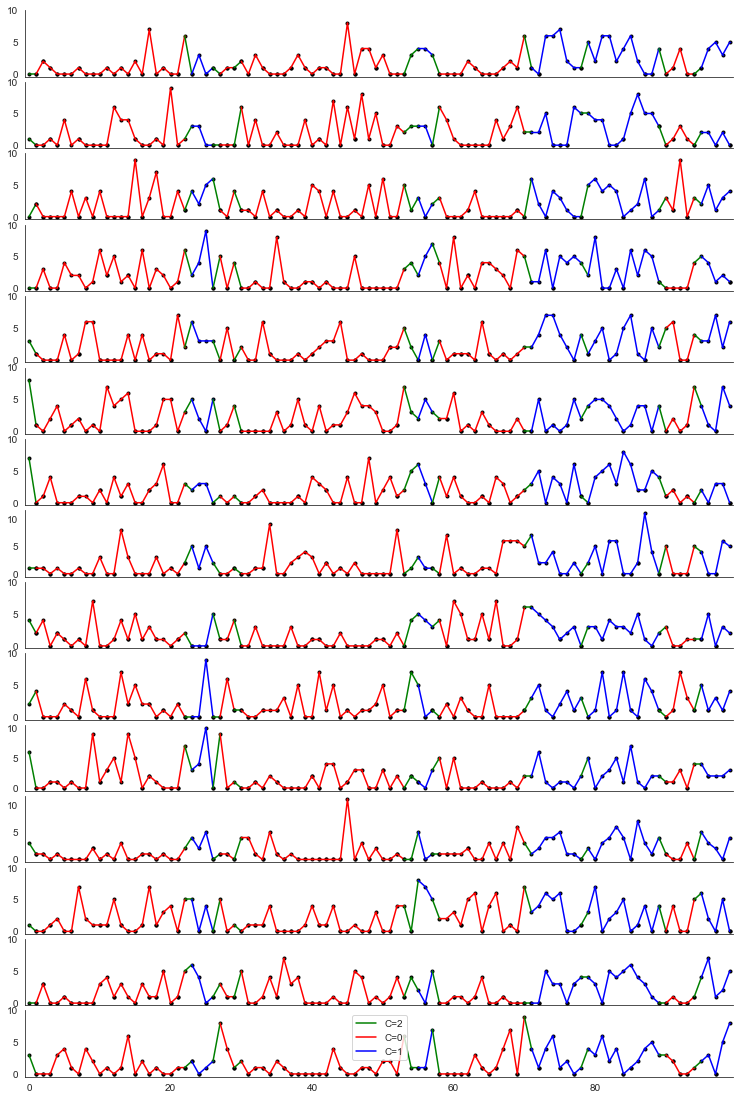

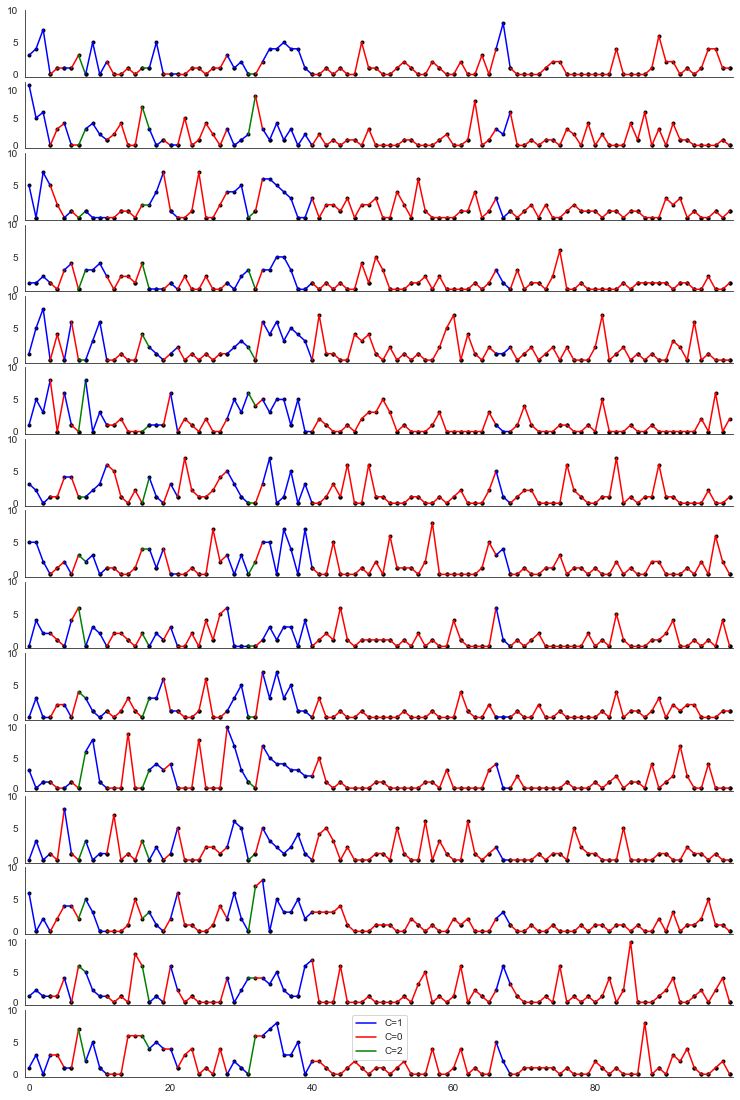

In [17]:
C, z, x = simulate(15,100,2,0.7055757575757575, 0.8333333333333334, 0.14066339066339067, np.array([0.3600802407221665, 3.7693836978131214]))
plot(x,z,C)

plot(dat,zs,Cs)

# print(dat)